# Quark-Gluon

Information about the dataset: https://arxiv.org/abs/1902.08276

In [1]:
import jax

from quantum_transformers.utils import plot_image
from quantum_transformers.datasets import get_quark_gluon_dataloaders
from quantum_transformers.training import train_and_evaluate
from quantum_transformers.transformers import VisionTransformer
from quantum_transformers.quantum_layer import get_circuit

data_dir = '/global/cfs/cdirs/m4392/salcc/data'

2023-09-25 04:25:14.611275: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-25 04:25:14.611424: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-25 04:25:14.611440: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-25 04:25:17.204344: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Please first ``pip install -U cirq`` to enable related functionality in translation module


In [2]:
for d in jax.devices():
    print(d, d.device_kind)

gpu:0 NVIDIA A100-SXM4-40GB


(125, 125, 3)


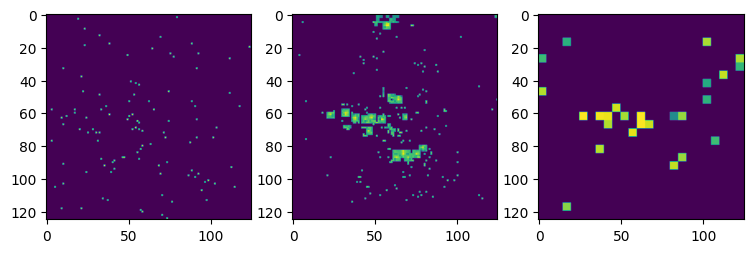

In [3]:
qg_train_dataloader, qg_val_dataloader, qg_test_dataloader = get_quark_gluon_dataloaders(batch_size=256, data_dir=data_dir)
first_image = next(iter(qg_train_dataloader))[0][0]
print(first_image.shape)
plot_image(first_image, abs_log=True)

In [4]:
model = VisionTransformer(num_classes=2, patch_size=10, hidden_size=8, num_heads=2, num_transformer_blocks=4, mlp_hidden_size=4,
                          quantum_attn_circuit=get_circuit(), quantum_mlp_circuit=get_circuit())
test_loss, test_auc, test_fpr, test_tpr = train_and_evaluate(model, qg_train_dataloader, qg_val_dataloader, qg_test_dataloader, num_classes=2, num_epochs=25)

Epoch   6/50:   7%|▋         | 201/2791 [02:06<27:15,  1.58batch/s]                                                                                                                                                            


KeyboardInterrupt: 

In [ ]:
import pickle
with open('qg_pr.pkl', 'wb') as f:
    pickle.dump((test_fpr, test_tpr, test_auc / 100), f)